In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import math
from functools import reduce
from math import gamma
from operator import mul
from scipy.special import loggamma
from scipy.stats import dirichlet, multivariate_normal

import torch
import tikzplotlib

# Define calculations and plottings tools

561


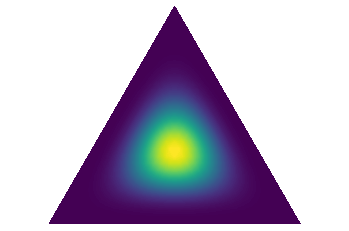

In [8]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)


"""
plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')
"""

midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def logistic_transform(x):
    
    x_D = x[:-1]
    #print("x_D: ", x_D, x[-1])
    out = np.log(x/x[-1])
    return(out)

def softmax_transform(a):
    x = np.exp(a)/np.sum(np.exp(a))
    return(x)

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))    

class Dirichlet(object):
    def __init__(self, alpha):
        self._alpha = np.array(alpha)
        self._coef = 1/beta_function(alpha)
        
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    
class Normal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.const = 1 / (np.sqrt((2*np.pi)**3 * np.linalg.det(Sigma)))
        
    def pdf(self, x):
        """Calculate 3D Gaussian"""
        y = self.const * np.exp(-0.5 * (x - self.mu).T @ self.Sigma @ (x - self.mu))
        return(y)
    
class logitNormal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.const = 1/ (np.sqrt(np.linalg.det(2 * np.pi * self.Sigma)))
        
    def pdf(self, x):
        part_one = self.const / np.prod(x)
        logistic = logistic_transform(x)
        part_two = np.exp(-0.5*(logistic - self.mu).T @ self.Sigma @ (logistic - self.mu))
        y = part_one * part_two
        return(y)

def draw_pdf_contours(dist, nlevels=200, subdiv=5, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    xys = [xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)]
    #print(len(pvals))
    #print(xys)
    print(len(xys))

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    
draw_pdf_contours(Dirichlet([5, 5, 5]))

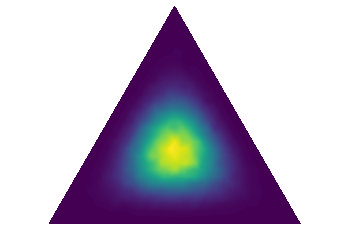

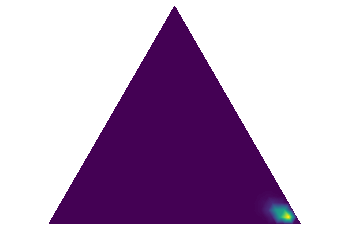

In [9]:
def argmin_norm(sample, positions):
    return(np.argmin(np.sum(np.square(sample - positions), axis=1)))

def sample_dirichlet_contours(alpha, nlevels=200, subdiv=5, num_samples=100000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)
    counts = np.zeros(len(xys))
    for x in dirichlet_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show()
    
def sample_Normal_contours(mu, sigma, nlevels=200, subdiv=5, num_samples=100000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    counts = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show()
    
sample_dirichlet_contours(np.array([5, 5, 5]))
sample_Normal_contours(np.array([-1, 2, -1]), 0.1*np.eye(3))

In [11]:
#test the transformations from Gaussian to Dirichlet and back

def get_mu_from_Dirichlet(alpha):
    K = len(alpha)
    mu = []
    for i in range(K):
        mu_i = np.log(alpha[i]) - 1/K * np.sum(np.log(alpha))
        mu.append(mu_i)
        
    return(np.array(mu))

def sigma_regularizer(Sigma):
    
    Sigma_new = np.zeros(np.shape(Sigma))
    n = len(Sigma[0])
    for i in range(n):
        for j in range(n):
            Sigma_new[i][j] = Sigma[i][j]  - Sigma[i] @ Sigma[:,j] * 1/Sigma.sum()
        
    return(Sigma_new)

def get_Sigma_from_Dirichlet(alpha):
    K = len(alpha)
    sum_of_inv = 1/K * np.sum(1/np.array(alpha))
    Sigma = np.zeros((K,K))
    for k in range(K):
        for l in range(K):
            delta = 1 if k==l else 0
            Sigma[k][l] = delta * 1/alpha[k] - 1/K*(1/alpha[k] + 1/alpha[l] - sum_of_inv)
            
    return(Sigma)



def get_alpha_from_Normal(mu, Sigma):
    alpha = []
    K = len(Sigma[0])
    sum_exp = np.sum(np.exp(-1*np.array(mu)))
    for k in range(K):
        alpha.append(1/Sigma[k][k]*(1 - 2/K + np.exp(mu[k])/K**2 * sum_exp))
        
    return(alpha)

def get_alpha_from_Normal_batch(mu, Sigma):
    mu, Sigma = torch.from_numpy(mu), torch.from_numpy(Sigma)
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*torch.Tensor(mu)), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    assert(alpha.size() == mu.size())
    
    return(alpha)

def alphas_norm(alphas):
    alphas = np.array(alphas)
    return(alphas/alphas.sum(axis=1).reshape(-1,1))

def alphas_variance(alphas):
    alphas = np.array(alphas)
    norm = alphas_norm(alphas)
    nom = norm * (1 - norm)
    den = alphas.sum(axis=1).reshape(-1,1) + 1
    return(nom/den)

def get_norm_variance_alphas(alphas):
    eps=10e-20
    a = np.array(alphas)
    a /= (np.sqrt(alphas_variance(a)) + eps)
    #a /= a.sum(1).reshape(-1,1)
    return(a)

def get_alphas_mS_batch(mu, Sigma):
    
    n = mu.size(0)
    alphas = torch.zeros(n, mu.size(1))
    for i in range(n):
        alphas[i] = get_alphas_from_mS(mu[i], Sigma[i])
        
    return(alphas)

from scipy.special import digamma, polygamma

alpha_test = np.array([1.3, 1.3])
print("alpha start: ", alpha_test)
mu_test = get_mu_from_Dirichlet(alpha_test)
print("mu: ", mu_test)
Sigma_test = get_Sigma_from_Dirichlet(alpha_test)
print("Sigma: ", Sigma_test)
alpha_end = get_alpha_from_Normal(mu_test, Sigma_test)
print("alpha end: ", alpha_end)

alpha start:  [1.3 1.3]
mu:  [0. 0.]
Sigma:  [[ 0.38461538 -0.38461538]
 [-0.38461538  0.38461538]]
alpha end:  [1.3, 1.3]


# make the plots

## Plot 1: show the plots for 3 matrices

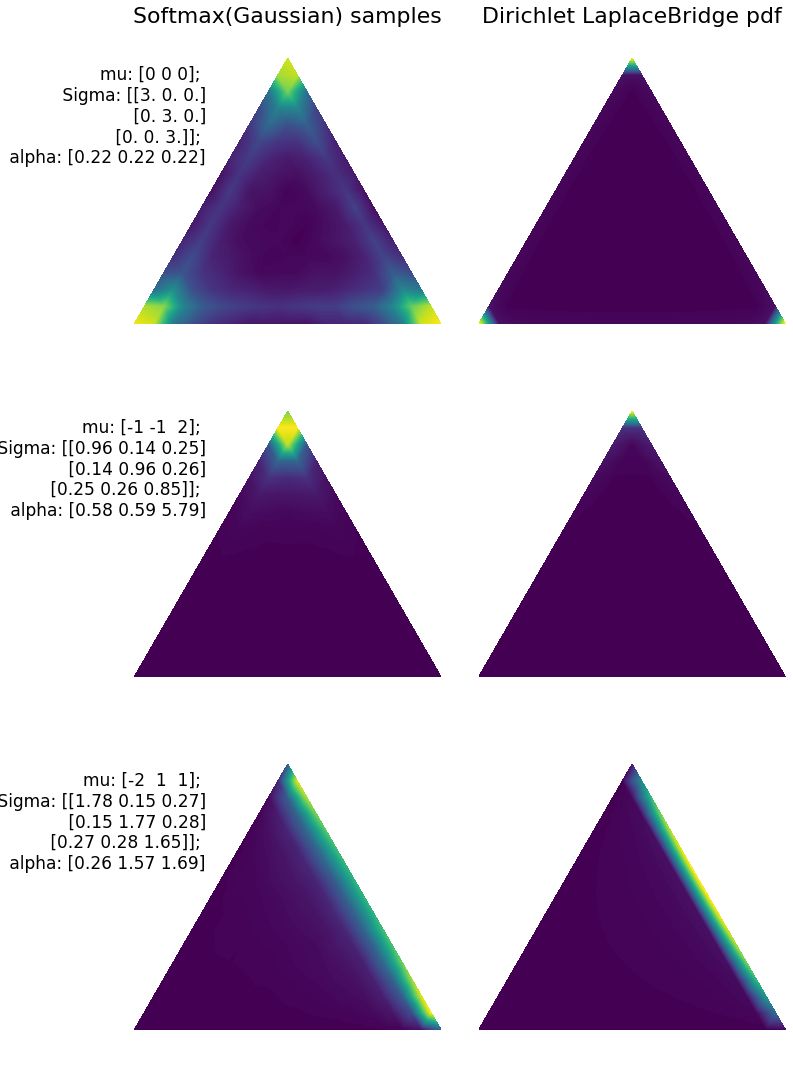

In [42]:
#Tests for the paper

num_samples = 100000
nlevels=200
subdiv=4

MUs_3s = [[0,0,0],
       [-1,-1,2],
       [-2,1,1]]
MUs_3s_vis = np.around(MUs_3s, 2)
SIGMAs_3s = [3*np.eye(3),
          0.1*np.array([[ 9.5938,  1.4385,  2.5147],
         [ 1.4385,  9.5551,  2.5534],
         [ 2.5147,  2.5534,  8.4789]]),
         0.1*np.array([[17.7842,  1.4664,  2.7132],
         [ 1.4664, 17.7394,  2.7580],
         [ 2.7132,  2.7580, 16.4925]])]
SIGMAs_3s_vis = np.around(SIGMAs_3s, 2)

ALPHAs_3s = [get_alpha_from_Normal(m,s) for m,s in zip(MUs_3s, SIGMAs_3s)]
ALPHAs_3s_vis = np.around(ALPHAs_3s, 2)

cols = ['Softmax(Gaussian) samples', 'Dirichlet LaplaceBridge pdf']
rows = ['mu: {}; \n Sigma: {}; \n alpha: {}'.format(m, s, a) for m,s,a in zip(MUs_3s_vis, SIGMAs_3s_vis, ALPHAs_3s_vis)]

fig, axs = plt.subplots(nrows=len(MUs_3s), ncols=2, sharex=False, figsize=(11, 15))

for idx, (mu, Sigma, alpha) in enumerate(zip(MUs_3s, SIGMAs_3s, ALPHAs_3s)):
    

    #VALUES
    #softmax(samples)
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    #dirichlet_samples
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

    #PLOTS
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    #plot softmax(Gaussian) samples
    counts_n = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts_n[argmin_norm(x, xys)] += 1

    pvals_n = counts_n/num_samples

    axs[idx][0].tricontourf(trimesh, pvals_n, nlevels)
    axs[idx][0].axis('equal')
    axs[idx][0].set_xlim(0, 1)
    axs[idx][0].set_ylim(0, 0.75**0.5)
    axs[idx][0].axis('off')

    
    """
    #plot dirichlet samples
    counts_d = np.zeros(len(xys))
    for x in dirichlet_samples:
        counts_d[argmin_norm(x, xys)] += 1

    pvals_d = counts_d/num_samples

    axs[idx][1].tricontourf(trimesh, pvals_d, nlevels)
    axs[idx][1].axis('equal')
    axs[idx][1].set_xlim(0, 1)
    axs[idx][1].set_ylim(0, 0.75**0.5)
    axs[idx][1].axis('off')
    #"""
    
    #"""
    #plot Dirichlet McKay pdf
    dist_McKay = Dirichlet(alpha)
    pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    axs[idx][1].tricontourf(trimesh, pvals_McKay, nlevels)
    axs[idx][1].axis('equal')
    axs[idx][1].set_xlim(0, 1)
    axs[idx][1].set_ylim(0, 0.75**0.5)
    axs[idx][1].axis('off')
    #"""
        

pad_top =  0 # in points

pad_y = 75
pad_left = -210

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad_top),
                xycoords='axes fraction', textcoords='offset points',
                size=22, ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad_left, pad_y),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=17, ha='right', va='center')        
        
fig.tight_layout()
plt.savefig('figures/comparison3D_3samples.pdf')
#tikzplotlib.save('figures/comparison3D_3samples.tikz', dpi=50)
plt.show()   
    

## Plot 2: show that increasing uncertainty in the Normal also increases uncertainty in the Dirichlet

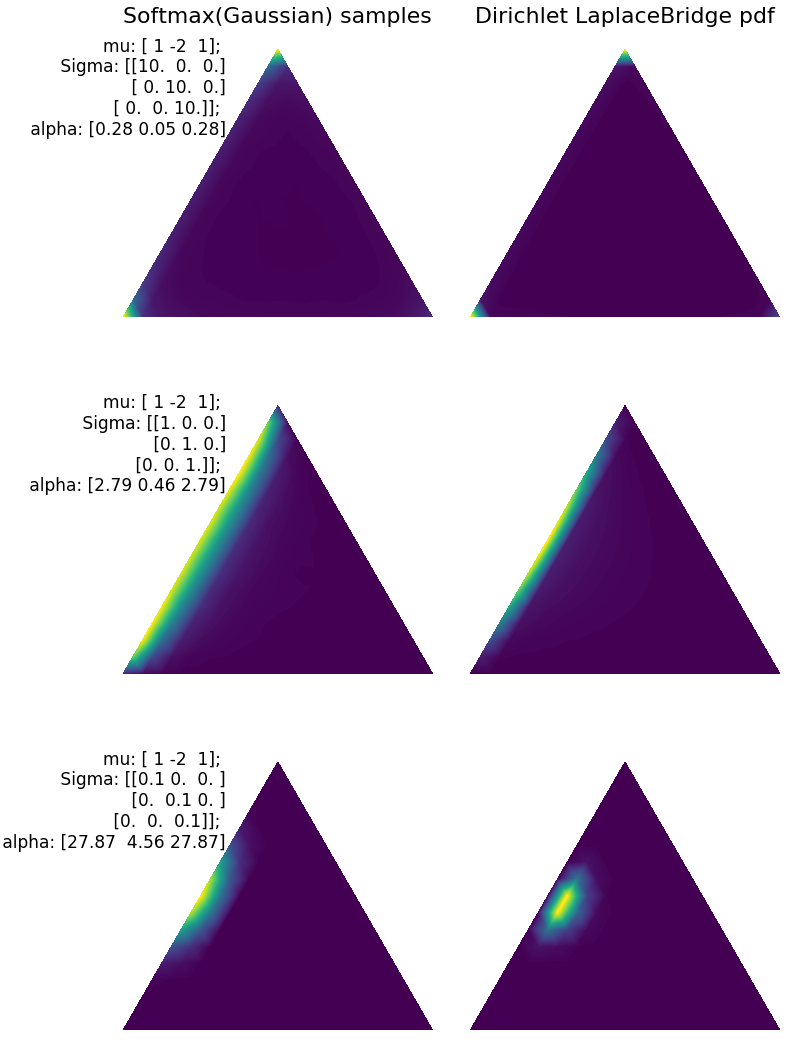

In [55]:
#Tests for the paper

num_samples = 100000
nlevels=200
subdiv=4

MUs_unc = [[1, -2, 1],
           [1, -2, 1],
           [1, -2, 1]]
MUs_unc_vis = np.around(MUs_unc, 2)
SIGMAs_unc = [10*np.eye(3),
              1*np.eye(3), 
              0.1*np.eye(3)]
SIGMAs_unc_vis = np.around(SIGMAs_unc, 2)

ALPHAs_unc = [get_alpha_from_Normal(m,s) for m,s in zip(MUs_unc, SIGMAs_unc)]
ALPHAs_unc_vis = np.around(ALPHAs_unc, 2)

cols = ['Softmax(Gaussian) samples', 'Dirichlet LaplaceBridge pdf']
rows = ['mu: {}; \n Sigma: {}; \n alpha: {}'.format(m, s, a) for m,s,a in zip(MUs_unc_vis, SIGMAs_unc_vis, ALPHAs_unc_vis)]

fig, axs = plt.subplots(nrows=len(MUs_unc), ncols=2, sharex=False, figsize=(11, 15))

for idx, (mu, Sigma, alpha) in enumerate(zip(MUs_unc, SIGMAs_unc, ALPHAs_unc)):
    

    #VALUES
    #softmax(samples)
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    #dirichlet_samples
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

    #PLOTS
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    #plot softmax(Gaussian) samples
    counts_n = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts_n[argmin_norm(x, xys)] += 1

    pvals_n = counts_n/num_samples

    axs[idx][0].tricontourf(trimesh, pvals_n, nlevels)
    axs[idx][0].axis('equal')
    axs[idx][0].set_xlim(0, 1)
    axs[idx][0].set_ylim(0, 0.75**0.5)
    axs[idx][0].axis('off')

    
    """
    #plot dirichlet samples
    counts_d = np.zeros(len(xys))
    for x in dirichlet_samples:
        counts_d[argmin_norm(x, xys)] += 1

    pvals_d = counts_d/num_samples

    axs[idx][1].tricontourf(trimesh, pvals_d, nlevels)
    axs[idx][1].axis('equal')
    axs[idx][1].set_xlim(0, 1)
    axs[idx][1].set_ylim(0, 0.75**0.5)
    axs[idx][1].axis('off')
    #"""
    
    #"""
    #plot Dirichlet McKay pdf
    dist_McKay = Dirichlet(alpha)
    pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    axs[idx][1].tricontourf(trimesh, pvals_McKay, nlevels)
    axs[idx][1].axis('equal')
    axs[idx][1].set_xlim(0, 1)
    axs[idx][1].set_ylim(0, 0.75**0.5)
    axs[idx][1].axis('off')
    #"""
        

pad_top =  0 # in points

pad_y = 95
pad_left = -230

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad_top),
                xycoords='axes fraction', textcoords='offset points',
                size=22, ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad_left, pad_y),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=17, ha='right', va='center')         
        
fig.tight_layout()
plt.savefig('figures/comparison3D_Uncertainty.pdf')
plt.show()   
    

## Plot 3: show that similar MAP is not same distribution

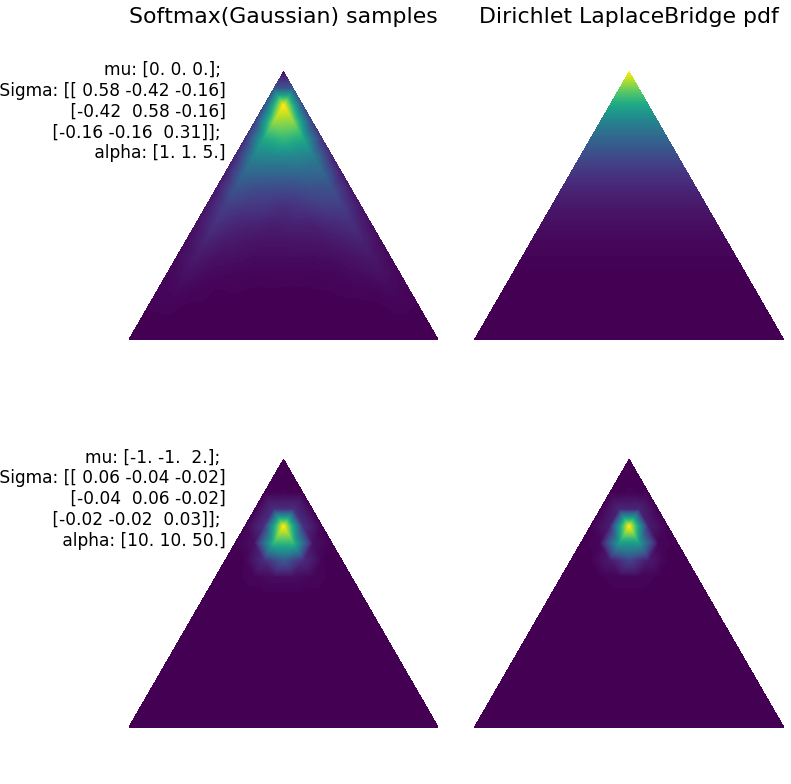

In [56]:
#Tests for the paper

num_samples = 100000
nlevels=200
subdiv=4

MUs_sMAP = [get_mu_from_Dirichlet([1,1,5]),
            get_mu_from_Dirichlet([10,10,50])]
MUs_sMAP_vis = np.around(MUs, 2)
SIGMAs_sMAP = [get_Sigma_from_Dirichlet([1,1,5]),
               get_Sigma_from_Dirichlet([10,10,50])]
SIGMAs_sMAP_vis = np.around(SIGMAs_sMAP, 2)

ALPHAs_sMAP = [get_alpha_from_Normal(m,s) for m,s in zip(MUs_sMAP, SIGMAs_sMAP)]
ALPHAs_sMAP_vis = np.around(ALPHAs_sMAP, 2)

cols = ['Softmax(Gaussian) samples', 'Dirichlet LaplaceBridge pdf']
rows = ['mu: {}; \n Sigma: {}; \n alpha: {}'.format(m, s, a) for m,s,a in zip(MUs_sMAP_vis, SIGMAs_sMAP_vis, ALPHAs_sMAP_vis)]

fig, axs = plt.subplots(nrows=len(MUs_sMAP), ncols=2, sharex=False, figsize=(11, 11))

for idx, (mu, Sigma, alpha) in enumerate(zip(MUs_sMAP, SIGMAs_sMAP, ALPHAs_sMAP)):
    

    #VALUES
    #softmax(samples)
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    #dirichlet_samples
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

    #PLOTS
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    #plot softmax(Gaussian) samples
    counts_n = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts_n[argmin_norm(x, xys)] += 1

    pvals_n = counts_n/num_samples

    axs[idx][0].tricontourf(trimesh, pvals_n, nlevels)
    axs[idx][0].axis('equal')
    axs[idx][0].set_xlim(0, 1)
    axs[idx][0].set_ylim(0, 0.75**0.5)
    axs[idx][0].axis('off')

    
    """
    #plot dirichlet samples
    counts_d = np.zeros(len(xys))
    for x in dirichlet_samples:
        counts_d[argmin_norm(x, xys)] += 1

    pvals_d = counts_d/num_samples

    axs[idx][1].tricontourf(trimesh, pvals_d, nlevels)
    axs[idx][1].axis('equal')
    axs[idx][1].set_xlim(0, 1)
    axs[idx][1].set_ylim(0, 0.75**0.5)
    axs[idx][1].axis('off')
    #"""
    
    #"""
    #plot Dirichlet McKay pdf
    dist_McKay = Dirichlet(alpha)
    pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    axs[idx][1].tricontourf(trimesh, pvals_McKay, nlevels)
    axs[idx][1].axis('equal')
    axs[idx][1].set_xlim(0, 1)
    axs[idx][1].set_ylim(0, 0.75**0.5)
    axs[idx][1].axis('off')
    #"""
        

pad_top =  0 # in points

pad_y = 95
pad_left = -230

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad_top),
                xycoords='axes fraction', textcoords='offset points',
                size=22, ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad_left, pad_y),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=17, ha='right', va='center')        
        
fig.tight_layout()
plt.savefig('figures/comparison3D_sMAP.pdf')
plt.show()   
    